In [4]:
import tensorflow as tf
from plot_utils import plot_train_process

In [5]:
poem_path = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [6]:
poem = open(poem_path, 'rb').read().decode(encoding='utf-8')
print(poem[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [7]:
vocab = sorted(set(poem))
vocab_size = len(vocab)
print('vocabulary size:', vocab_size)

vocabulary size: 65


In [8]:
char_to_id = tf.keras.layers.StringLookup(vocabulary=vocab)
print(char_to_id([['A', '\n', 'c', 'z'], ['B', 'k', 'd', '\t']]))
id_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_id.get_vocabulary(), invert=True)
print(id_to_char([65, 3, -1, 100]))

tf.Tensor(
[[14  1 42 65]
 [15 50 43  0]], shape=(2, 4), dtype=int64)
tf.Tensor([b'z' b'!' b'[UNK]' b'[UNK]'], shape=(4,), dtype=string)


### Create Dataset

In [9]:
sequence_len = 100

poem_char = tf.strings.unicode_split(poem, 'UTF-8')
sequence_ds = tf.data.Dataset.from_tensor_slices(char_to_id(poem_char)).batch(sequence_len + 1, drop_remainder=True)
len(sequence_ds)

11043

In [10]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

poem_ds = sequence_ds.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

poem_ds = (
    poem_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

poem_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Build Model

In [11]:
class Trainer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=256, rnn_units=1024):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.emb = tf.keras.layers.Embedding(vocab_size + 1, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True,
                                        return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size + 1)

    def call(self, X, state=None, return_state=False, training=False):
        X = self.emb(X, training=training)
        if state is None:
            state = self.gru.get_initial_state(X)
        X, state = self.gru(X, initial_state=state, training=training)
        X = self.dense(X, training=training)

        if return_state:
            return X, state
        else:
            return X

model = Trainer(vocab_size)
for X, labels in poem_ds.take(1):
    print(X.shape)
    print(labels.shape)
    output = model(X)
print(output.shape)
model.summary()

(64, 100)
(64, 100)
(64, 100, 66)
Model: "trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


### Train

Epoch 1/50
138/138 [==============================] - 12s 66ms/step - loss: 2.8187 - accuracy: 0.2581 - val_loss: 2.2568 - val_accuracy: 0.3544
Epoch 2/50
138/138 [==============================] - 9s 67ms/step - loss: 2.0911 - accuracy: 0.3920 - val_loss: 1.9280 - val_accuracy: 0.4330
Epoch 3/50
138/138 [==============================] - 9s 67ms/step - loss: 1.8139 - accuracy: 0.4639 - val_loss: 1.6981 - val_accuracy: 0.4941
Epoch 4/50
138/138 [==============================] - 10s 70ms/step - loss: 1.6370 - accuracy: 0.5116 - val_loss: 1.5592 - val_accuracy: 0.5310
Epoch 5/50
138/138 [==============================] - 9s 68ms/step - loss: 1.5212 - accuracy: 0.5429 - val_loss: 1.4673 - val_accuracy: 0.5583
Epoch 6/50
138/138 [==============================] - 9s 69ms/step - loss: 1.4437 - accuracy: 0.5629 - val_loss: 1.3912 - val_accuracy: 0.5760
Epoch 7/50
138/138 [==============================] - 9s 68ms/step - loss: 1.3860 - accuracy: 0.5773 - val_loss: 1.3398 - val_accuracy: 0.58

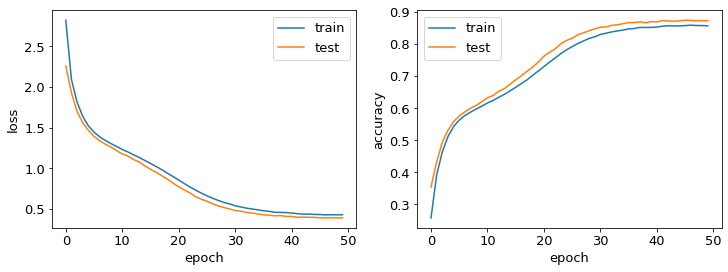

In [12]:
val_ds = poem_ds.take(len(poem_ds) // 5)
train_ds = poem_ds.skip(len(poem_ds) // 5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile('adam', loss=loss, metrics=['accuracy'])
tf.config.run_functions_eagerly(True)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)
plot_train_process(history)

In [29]:
class Generator(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def step(self, X, state):
        if len(X.shape) == 1:
            X = tf.reshape(X, (1, -1)) # batch_size = 1
        Y_pred, state = self.model(X, state=state, return_state=True)
        return tf.random.categorical(Y_pred[0, -1:, :], num_samples=1), state

    def call(self, X0, num_gen=1):
        X = tf.strings.unicode_split(X0, 'UTF-8')
        X = char_to_id(X)
        X = tf.reshape(X, (1, -1))
        outputs = []
        state = None
        for t in range(num_gen):
            X, state = self.step(X, state)
            outputs.append(X)
        ids = tf.concat(outputs, axis=-1)[0]
        sentence = self.id_to_sentence(ids)
        return (X0 + sentence).numpy().decode()

    def id_to_sentence(self, ids):
        chars = id_to_char(ids)
        sentence = tf.strings.reduce_join(chars, axis=-1)
        return sentence

In [41]:
gen = Generator(model)
print(gen(tf.constant('Nice!'), 150))

Nice!
Why, train shall go to that. The day is born,
In arms suns to austress with whom, the bigger.

HASTINGS:
Gramercy, fly.
Farewell, my lord: such is th
